# Mask R-CNN - Train on Lettuce Dataset


This notebook shows how to train Mask R-CNN on your own dataset.


In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_images

from samples.lettuce import lettuce

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "model_weights/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


### Configurations

In [2]:
LETTUCE_DIR = os.path.join(ROOT_DIR, "datasets/LETTUCE_V0")

config = Config()
# Override the training configurations with a few
# changes for inferencing.
class LettuceConfig(config.__class__):
    # Run detection on one image at a time


    NAME = "lettuce"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    
     # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes
    
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    BACKBONE_STRIDES = [4,8,16,32,64]
    
    ##********** 1)ANCHORS GENERATION - for RPN*********
    
    #     Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 24,32, 48) 
    TOP_DOWN_PYRAMID_SIZE = 256
    
    ##********** 2)PROPOSAL LAYER ********* (no deep learning involved here)
    
     # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 300 ##in dataset generation

    ## tf.image.non_max_suppression(boxes,scores,max_output_size,iou_threshold=0.5,...)
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD=0.7
    #A float representing the threshold for deciding whether boxes overlap too much with respect to IOU.    
    ## POST_NMS_ROIS_TRAINING~ POST_NMS_ROIS_INFERENCE ~proposal_count ~ max_output_size
    
    POST_NMS_ROIS_TRAINING=1800
    POST_NMS_ROIS_INFERENCE=1100
    ##********** 3a)TRAINING - DETECTION TARGET LAYER *********
    
    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 300
    
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 300
    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33
    
    ##********** 3B)INFERENCE - DETECTION  LAYER *********

    
    # Non-maximum suppression threshold for detection in DetectionLater
    DETECTION_NMS_THRESHOLD = 0.5  # 0.5 above iou_threshold

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped in DetectionLater
    DETECTION_MIN_CONFIDENCE = 0.7

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 300

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 130

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 40
    LEARNING_RATE = 0.001

    TRAIN_BN = False

    
    
config = LettuceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    Configurations:

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset



In [4]:

# Training dataset
dataset_train = lettuce.LettuceDataset()
dataset_train.load_lettuce(LETTUCE_DIR, "train")
dataset_train.prepare()
print('Training images: {}'.format(len(dataset_train.image_ids)))
# Validation dataset
dataset_val= lettuce.LettuceDataset()
dataset_val.load_lettuce(LETTUCE_DIR, "val")
dataset_val.prepare()
print('Validation images: {}'.format(len(dataset_val.image_ids)))
# Test dataset
dataset_test= lettuce.LettuceDataset()
dataset_test.load_lettuce(LETTUCE_DIR, "test")
dataset_test.prepare()
print('Validation images: {}'.format(len(dataset_test.image_ids)))

Training images: 122
Validation images: 31
Validation images: 39


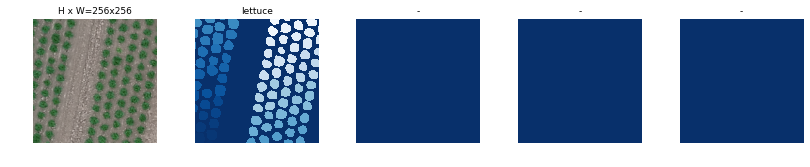

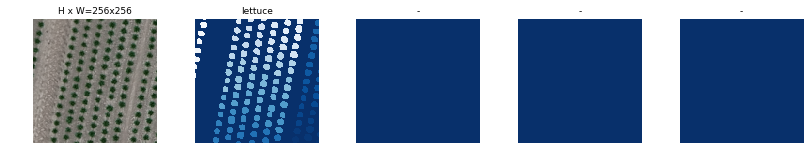

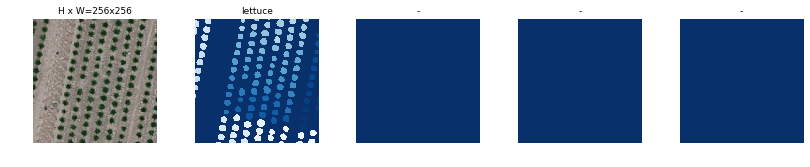

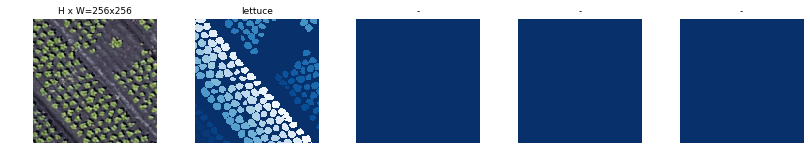

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# Which weights to start with?
init_with = "retrain"  # imagenet, coco,last, retrain
model_path_retrain='path/to/model.h5'
retrain_learning_rate = config.LEARNING_RATE

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    
elif init_with == 'retrain':
    print("Loading weights from ", model_path_retrain)
    model.load_weights(model_path_retrain, by_name=True)
    config.LEARNING_RATE = retrain_learning_rate
    
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


Loading weights from  /home/melissande/Desktop/git_repositories/Mask_RCNN/logs/potato20190824T1531/best_mask_rcnn_potato_0290.h5


In [12]:
# confirm Keras sees the GPU
from keras import backend
print(len(backend.tensorflow_backend._get_available_gpus()) > 0)

True


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [13]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.


import imgaug


augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.Rot90(1),
                    #imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            augmentation=augmentation,
            epochs=638, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/melissande/Desktop/git_repositories/Mask_RCNN/logs/lettuce20190824T2337/mask_rcnn_lettuce_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4   

/home/melissande/hb/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/melissande/hb/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/638
130/130 [==============================] - 172s 1s/step - loss: 1.2032 - rpn_class_loss: 0.1821 - rpn_bbox_loss: 0.3131 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.1760 - mrcnn_mask_loss: 0.2647 - val_loss: 1.2201 - val_rpn_class_loss: 0.1563 - val_rpn_bbox_loss: 0.4639 - val_mrcnn_class_loss: 0.1769 - val_mrcnn_bbox_loss: 0.1449 - val_mrcnn_mask_loss: 0.2781
Epoch 2/638
130/130 [==============================] - 112s 864ms/step - loss: 2.0163 - rpn_class_loss: 0.2424 - rpn_bbox_loss: 0.4977 - mrcnn_class_loss: 0.4965 - mrcnn_bbox_loss: 0.3643 - mrcnn_mask_loss: 0.4154 - val_loss: 1.0730 - val_rpn_class_loss: 0.1483 - val_rpn_bbox_loss: 0.2686 - val_mrcnn_class_loss: 0.1548 - val_mrcnn_bbox_loss: 0.2001 - val_mrcnn_mask_loss: 0.3013
Epoch 3/638
130/130 [==============================] - 114s 878ms/step - loss: 1.9942 - rpn_class_loss: 0.2544 - rpn_bbox_loss: 0.5146 - mrcnn_class_loss: 0.4230 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4142 - val_loss: 1.2210 - val_rp

130/130 [==============================] - 113s 867ms/step - loss: 1.6437 - rpn_class_loss: 0.1669 - rpn_bbox_loss: 0.4229 - mrcnn_class_loss: 0.3955 - mrcnn_bbox_loss: 0.3096 - mrcnn_mask_loss: 0.3489 - val_loss: 0.7911 - val_rpn_class_loss: 0.0470 - val_rpn_bbox_loss: 0.2801 - val_mrcnn_class_loss: 0.1625 - val_mrcnn_bbox_loss: 0.1078 - val_mrcnn_mask_loss: 0.1937
Epoch 44/638
130/130 [==============================] - 112s 859ms/step - loss: 1.7510 - rpn_class_loss: 0.1999 - rpn_bbox_loss: 0.4248 - mrcnn_class_loss: 0.4220 - mrcnn_bbox_loss: 0.3267 - mrcnn_mask_loss: 0.3776 - val_loss: 0.7589 - val_rpn_class_loss: 0.0321 - val_rpn_bbox_loss: 0.2737 - val_mrcnn_class_loss: 0.1496 - val_mrcnn_bbox_loss: 0.1068 - val_mrcnn_mask_loss: 0.1967
Epoch 45/638
130/130 [==============================] - 112s 862ms/step - loss: 1.7617 - rpn_class_loss: 0.1958 - rpn_bbox_loss: 0.4249 - mrcnn_class_loss: 0.4038 - mrcnn_bbox_loss: 0.3538 - mrcnn_mask_loss: 0.3834 - val_loss: 0.9588 - val_rpn_class

130/130 [==============================] - 112s 863ms/step - loss: 1.4776 - rpn_class_loss: 0.1635 - rpn_bbox_loss: 0.3531 - mrcnn_class_loss: 0.3508 - mrcnn_bbox_loss: 0.2814 - mrcnn_mask_loss: 0.3289 - val_loss: 0.8365 - val_rpn_class_loss: 0.0747 - val_rpn_bbox_loss: 0.2179 - val_mrcnn_class_loss: 0.1835 - val_mrcnn_bbox_loss: 0.1365 - val_mrcnn_mask_loss: 0.2239
Epoch 86/638
130/130 [==============================] - 112s 862ms/step - loss: 1.1225 - rpn_class_loss: 0.1094 - rpn_bbox_loss: 0.2681 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.2746 - val_loss: 0.7283 - val_rpn_class_loss: 0.0372 - val_rpn_bbox_loss: 0.2203 - val_mrcnn_class_loss: 0.1639 - val_mrcnn_bbox_loss: 0.1088 - val_mrcnn_mask_loss: 0.1981
Epoch 87/638
130/130 [==============================] - 112s 861ms/step - loss: 0.7046 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1912 - mrcnn_class_loss: 0.1480 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.2153 - val_loss: 0.6657 - val_rpn_class

130/130 [==============================] - 112s 862ms/step - loss: 1.0724 - rpn_class_loss: 0.0957 - rpn_bbox_loss: 0.2362 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.2792 - val_loss: 0.8947 - val_rpn_class_loss: 0.0300 - val_rpn_bbox_loss: 0.2153 - val_mrcnn_class_loss: 0.2127 - val_mrcnn_bbox_loss: 0.1550 - val_mrcnn_mask_loss: 0.2818
Epoch 128/638
130/130 [==============================] - 113s 873ms/step - loss: 1.1547 - rpn_class_loss: 0.1376 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.2835 - val_loss: 0.6358 - val_rpn_class_loss: 0.0217 - val_rpn_bbox_loss: 0.1524 - val_mrcnn_class_loss: 0.1539 - val_mrcnn_bbox_loss: 0.1079 - val_mrcnn_mask_loss: 0.1998
Epoch 129/638
130/130 [==============================] - 114s 879ms/step - loss: 1.6854 - rpn_class_loss: 0.1605 - rpn_bbox_loss: 0.3910 - mrcnn_class_loss: 0.4352 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.3782 - val_loss: 0.6817 - val_rpn_cla

130/130 [==============================] - 113s 866ms/step - loss: 1.0086 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 0.2358 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1833 - mrcnn_mask_loss: 0.2688 - val_loss: 0.6087 - val_rpn_class_loss: 0.0230 - val_rpn_bbox_loss: 0.1804 - val_mrcnn_class_loss: 0.1194 - val_mrcnn_bbox_loss: 0.1013 - val_mrcnn_mask_loss: 0.1846
Epoch 170/638
130/130 [==============================] - 113s 866ms/step - loss: 1.5527 - rpn_class_loss: 0.1598 - rpn_bbox_loss: 0.3737 - mrcnn_class_loss: 0.3772 - mrcnn_bbox_loss: 0.2911 - mrcnn_mask_loss: 0.3509 - val_loss: 0.7305 - val_rpn_class_loss: 0.0422 - val_rpn_bbox_loss: 0.1919 - val_mrcnn_class_loss: 0.1778 - val_mrcnn_bbox_loss: 0.1043 - val_mrcnn_mask_loss: 0.2142
Epoch 171/638
130/130 [==============================] - 113s 867ms/step - loss: 1.7147 - rpn_class_loss: 0.1851 - rpn_bbox_loss: 0.3779 - mrcnn_class_loss: 0.4432 - mrcnn_bbox_loss: 0.3342 - mrcnn_mask_loss: 0.3742 - val_loss: 0.6953 - val_rpn_cla

130/130 [==============================] - 113s 869ms/step - loss: 2.2744 - rpn_class_loss: 0.2613 - rpn_bbox_loss: 0.5209 - mrcnn_class_loss: 0.5736 - mrcnn_bbox_loss: 0.4451 - mrcnn_mask_loss: 0.4735 - val_loss: 0.7607 - val_rpn_class_loss: 0.0478 - val_rpn_bbox_loss: 0.2116 - val_mrcnn_class_loss: 0.1422 - val_mrcnn_bbox_loss: 0.1308 - val_mrcnn_mask_loss: 0.2284
Epoch 212/638
130/130 [==============================] - 113s 866ms/step - loss: 1.4530 - rpn_class_loss: 0.1391 - rpn_bbox_loss: 0.3268 - mrcnn_class_loss: 0.3884 - mrcnn_bbox_loss: 0.2629 - mrcnn_mask_loss: 0.3357 - val_loss: 0.6874 - val_rpn_class_loss: 0.0244 - val_rpn_bbox_loss: 0.2316 - val_mrcnn_class_loss: 0.1290 - val_mrcnn_bbox_loss: 0.1015 - val_mrcnn_mask_loss: 0.2008
Epoch 213/638
130/130 [==============================] - 112s 861ms/step - loss: 1.1756 - rpn_class_loss: 0.1135 - rpn_bbox_loss: 0.2659 - mrcnn_class_loss: 0.2990 - mrcnn_bbox_loss: 0.2126 - mrcnn_mask_loss: 0.2846 - val_loss: 0.7168 - val_rpn_cla

130/130 [==============================] - 112s 864ms/step - loss: 1.4542 - rpn_class_loss: 0.1426 - rpn_bbox_loss: 0.3211 - mrcnn_class_loss: 0.3679 - mrcnn_bbox_loss: 0.2770 - mrcnn_mask_loss: 0.3456 - val_loss: 0.7329 - val_rpn_class_loss: 0.0309 - val_rpn_bbox_loss: 0.1812 - val_mrcnn_class_loss: 0.1676 - val_mrcnn_bbox_loss: 0.1333 - val_mrcnn_mask_loss: 0.2198
Epoch 254/638
130/130 [==============================] - 112s 865ms/step - loss: 1.4923 - rpn_class_loss: 0.1507 - rpn_bbox_loss: 0.3291 - mrcnn_class_loss: 0.3868 - mrcnn_bbox_loss: 0.2770 - mrcnn_mask_loss: 0.3487 - val_loss: 0.7656 - val_rpn_class_loss: 0.0202 - val_rpn_bbox_loss: 0.2413 - val_mrcnn_class_loss: 0.1608 - val_mrcnn_bbox_loss: 0.1242 - val_mrcnn_mask_loss: 0.2190
Epoch 255/638
130/130 [==============================] - 113s 871ms/step - loss: 1.2031 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 0.2606 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.2314 - mrcnn_mask_loss: 0.2961 - val_loss: 0.6289 - val_rpn_cla

130/130 [==============================] - 112s 862ms/step - loss: 1.4735 - rpn_class_loss: 0.1465 - rpn_bbox_loss: 0.3311 - mrcnn_class_loss: 0.3718 - mrcnn_bbox_loss: 0.2773 - mrcnn_mask_loss: 0.3468 - val_loss: 0.8261 - val_rpn_class_loss: 0.0512 - val_rpn_bbox_loss: 0.2998 - val_mrcnn_class_loss: 0.1366 - val_mrcnn_bbox_loss: 0.1220 - val_mrcnn_mask_loss: 0.2164
Epoch 296/638
130/130 [==============================] - 113s 865ms/step - loss: 1.4052 - rpn_class_loss: 0.1226 - rpn_bbox_loss: 0.3017 - mrcnn_class_loss: 0.3761 - mrcnn_bbox_loss: 0.2660 - mrcnn_mask_loss: 0.3388 - val_loss: 0.7993 - val_rpn_class_loss: 0.0500 - val_rpn_bbox_loss: 0.2610 - val_mrcnn_class_loss: 0.1330 - val_mrcnn_bbox_loss: 0.1231 - val_mrcnn_mask_loss: 0.2321
Epoch 297/638
130/130 [==============================] - 113s 869ms/step - loss: 1.6402 - rpn_class_loss: 0.1718 - rpn_bbox_loss: 0.3757 - mrcnn_class_loss: 0.4132 - mrcnn_bbox_loss: 0.3050 - mrcnn_mask_loss: 0.3745 - val_loss: 0.5881 - val_rpn_cla

130/130 [==============================] - 112s 862ms/step - loss: 1.0501 - rpn_class_loss: 0.0865 - rpn_bbox_loss: 0.2312 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.1873 - mrcnn_mask_loss: 0.2777 - val_loss: 0.7762 - val_rpn_class_loss: 0.0548 - val_rpn_bbox_loss: 0.1880 - val_mrcnn_class_loss: 0.2015 - val_mrcnn_bbox_loss: 0.1219 - val_mrcnn_mask_loss: 0.2099
Epoch 338/638
130/130 [==============================] - 112s 861ms/step - loss: 1.2322 - rpn_class_loss: 0.1457 - rpn_bbox_loss: 0.2609 - mrcnn_class_loss: 0.3138 - mrcnn_bbox_loss: 0.2145 - mrcnn_mask_loss: 0.2973 - val_loss: 0.7331 - val_rpn_class_loss: 0.0439 - val_rpn_bbox_loss: 0.1700 - val_mrcnn_class_loss: 0.1751 - val_mrcnn_bbox_loss: 0.1200 - val_mrcnn_mask_loss: 0.2240
Epoch 339/638
130/130 [==============================] - 112s 863ms/step - loss: 1.7536 - rpn_class_loss: 0.1765 - rpn_bbox_loss: 0.3637 - mrcnn_class_loss: 0.4714 - mrcnn_bbox_loss: 0.3353 - mrcnn_mask_loss: 0.4068 - val_loss: 0.7156 - val_rpn_cla

130/130 [==============================] - 113s 867ms/step - loss: 1.2752 - rpn_class_loss: 0.1153 - rpn_bbox_loss: 0.2734 - mrcnn_class_loss: 0.3327 - mrcnn_bbox_loss: 0.2372 - mrcnn_mask_loss: 0.3165 - val_loss: 0.8484 - val_rpn_class_loss: 0.0497 - val_rpn_bbox_loss: 0.2495 - val_mrcnn_class_loss: 0.1827 - val_mrcnn_bbox_loss: 0.1256 - val_mrcnn_mask_loss: 0.2409
Epoch 380/638
130/130 [==============================] - 112s 863ms/step - loss: 1.9169 - rpn_class_loss: 0.2078 - rpn_bbox_loss: 0.4039 - mrcnn_class_loss: 0.5068 - mrcnn_bbox_loss: 0.3714 - mrcnn_mask_loss: 0.4270 - val_loss: 0.6868 - val_rpn_class_loss: 0.0430 - val_rpn_bbox_loss: 0.1964 - val_mrcnn_class_loss: 0.1383 - val_mrcnn_bbox_loss: 0.1055 - val_mrcnn_mask_loss: 0.2035
Epoch 381/638
130/130 [==============================] - 112s 864ms/step - loss: 1.2262 - rpn_class_loss: 0.1223 - rpn_bbox_loss: 0.2607 - mrcnn_class_loss: 0.3203 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.3016 - val_loss: 0.6785 - val_rpn_cla

130/130 [==============================] - 112s 865ms/step - loss: 1.5185 - rpn_class_loss: 0.1383 - rpn_bbox_loss: 0.3387 - mrcnn_class_loss: 0.3880 - mrcnn_bbox_loss: 0.2922 - mrcnn_mask_loss: 0.3612 - val_loss: 0.7414 - val_rpn_class_loss: 0.0503 - val_rpn_bbox_loss: 0.2695 - val_mrcnn_class_loss: 0.0993 - val_mrcnn_bbox_loss: 0.1160 - val_mrcnn_mask_loss: 0.2062
Epoch 422/638
130/130 [==============================] - 112s 864ms/step - loss: 1.0900 - rpn_class_loss: 0.1115 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.2912 - mrcnn_bbox_loss: 0.1896 - mrcnn_mask_loss: 0.2885 - val_loss: 0.7423 - val_rpn_class_loss: 0.0326 - val_rpn_bbox_loss: 0.2663 - val_mrcnn_class_loss: 0.1285 - val_mrcnn_bbox_loss: 0.1126 - val_mrcnn_mask_loss: 0.2023
Epoch 423/638
130/130 [==============================] - 112s 865ms/step - loss: 1.3818 - rpn_class_loss: 0.1298 - rpn_bbox_loss: 0.2727 - mrcnn_class_loss: 0.3853 - mrcnn_bbox_loss: 0.2495 - mrcnn_mask_loss: 0.3444 - val_loss: 0.5651 - val_rpn_cla

130/130 [==============================] - 113s 867ms/step - loss: 1.4285 - rpn_class_loss: 0.1461 - rpn_bbox_loss: 0.2674 - mrcnn_class_loss: 0.4035 - mrcnn_bbox_loss: 0.2589 - mrcnn_mask_loss: 0.3526 - val_loss: 0.8527 - val_rpn_class_loss: 0.0580 - val_rpn_bbox_loss: 0.2073 - val_mrcnn_class_loss: 0.1827 - val_mrcnn_bbox_loss: 0.1365 - val_mrcnn_mask_loss: 0.2680
Epoch 464/638
130/130 [==============================] - 113s 869ms/step - loss: 1.2943 - rpn_class_loss: 0.1177 - rpn_bbox_loss: 0.2692 - mrcnn_class_loss: 0.3519 - mrcnn_bbox_loss: 0.2327 - mrcnn_mask_loss: 0.3227 - val_loss: 0.7662 - val_rpn_class_loss: 0.0680 - val_rpn_bbox_loss: 0.1967 - val_mrcnn_class_loss: 0.1710 - val_mrcnn_bbox_loss: 0.1128 - val_mrcnn_mask_loss: 0.2178
Epoch 465/638
130/130 [==============================] - 113s 866ms/step - loss: 1.5264 - rpn_class_loss: 0.1523 - rpn_bbox_loss: 0.3378 - mrcnn_class_loss: 0.3985 - mrcnn_bbox_loss: 0.2790 - mrcnn_mask_loss: 0.3587 - val_loss: 0.6374 - val_rpn_cla

130/130 [==============================] - 115s 883ms/step - loss: 1.1510 - rpn_class_loss: 0.0932 - rpn_bbox_loss: 0.2140 - mrcnn_class_loss: 0.3193 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3091 - val_loss: 0.6963 - val_rpn_class_loss: 0.0349 - val_rpn_bbox_loss: 0.1726 - val_mrcnn_class_loss: 0.1716 - val_mrcnn_bbox_loss: 0.1076 - val_mrcnn_mask_loss: 0.2095
Epoch 506/638
130/130 [==============================] - 115s 882ms/step - loss: 0.9864 - rpn_class_loss: 0.0992 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.2726 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.2722 - val_loss: 0.7819 - val_rpn_class_loss: 0.0441 - val_rpn_bbox_loss: 0.1687 - val_mrcnn_class_loss: 0.2027 - val_mrcnn_bbox_loss: 0.1300 - val_mrcnn_mask_loss: 0.2364
Epoch 507/638
130/130 [==============================] - 115s 883ms/step - loss: 1.3908 - rpn_class_loss: 0.1399 - rpn_bbox_loss: 0.2929 - mrcnn_class_loss: 0.3634 - mrcnn_bbox_loss: 0.2555 - mrcnn_mask_loss: 0.3390 - val_loss: 0.7369 - val_rpn_cla

130/130 [==============================] - 112s 865ms/step - loss: 1.1509 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 0.2188 - mrcnn_class_loss: 0.3181 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.3058 - val_loss: 0.7305 - val_rpn_class_loss: 0.0410 - val_rpn_bbox_loss: 0.1715 - val_mrcnn_class_loss: 0.1669 - val_mrcnn_bbox_loss: 0.1234 - val_mrcnn_mask_loss: 0.2276
Epoch 548/638
130/130 [==============================] - 112s 863ms/step - loss: 1.3249 - rpn_class_loss: 0.1269 - rpn_bbox_loss: 0.2558 - mrcnn_class_loss: 0.3581 - mrcnn_bbox_loss: 0.2433 - mrcnn_mask_loss: 0.3407 - val_loss: 0.6461 - val_rpn_class_loss: 0.0252 - val_rpn_bbox_loss: 0.1631 - val_mrcnn_class_loss: 0.1487 - val_mrcnn_bbox_loss: 0.1035 - val_mrcnn_mask_loss: 0.2056
Epoch 549/638
130/130 [==============================] - 112s 864ms/step - loss: 0.9676 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 0.1994 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1858 - mrcnn_mask_loss: 0.2735 - val_loss: 0.6515 - val_rpn_cla

Process ForkPoolWorker-7:
Process ForkPoolWorker-3:
Process ForkPoolWorker-9:
Process ForkPoolWorker-24:
Process ForkPoolWorker-10:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-22:
Process ForkPoolWorker-20:
Process ForkPoolWorker-8:
Process ForkPoolWorker-21:
Process ForkPoolWorker-11:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-23:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  

Process ForkPoolWorker-12:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Process ForkPoolWorker-19:
Process ForkPoolWorker-18:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/melissande/hb/lib/python3.6/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/lib/python3.6/multiproce

KeyboardInterrupt
Process ForkPoolWorker-25:
Process ForkPoolWorker-38:
Process ForkPoolWorker-29:
Process ForkPoolWorker-31:
Process ForkPoolWorker-26:
Process ForkPoolWorker-34:
Process ForkPoolWorker-27:
Process ForkPoolWorker-33:
Process ForkPoolWorker-30:
Process ForkPoolWorker-28:
Process ForkPoolWorker-32:
Process ForkPoolWorker-36:
Process ForkPoolWorker-35:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-37:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocess

KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


KeyboardInterrupt: 

# Detection

In [10]:
class InferenceConfig(LettuceConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
#     DETECTION_MIN_CONFIDENCE =0.8
    
inference_config=InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/melissande/Desktop/git_repositories/Mask_RCNN/logs/lettuce20190801T1945/mask_rcnn_lettuce_0429.h5
Re-starting from epoch 429


original_image           shape: (256, 256, 3)         min:   13.00000  max:  200.00000  int64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (103,)                min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (103, 4)              min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 103)       min:    0.00000  max:    1.00000  bool


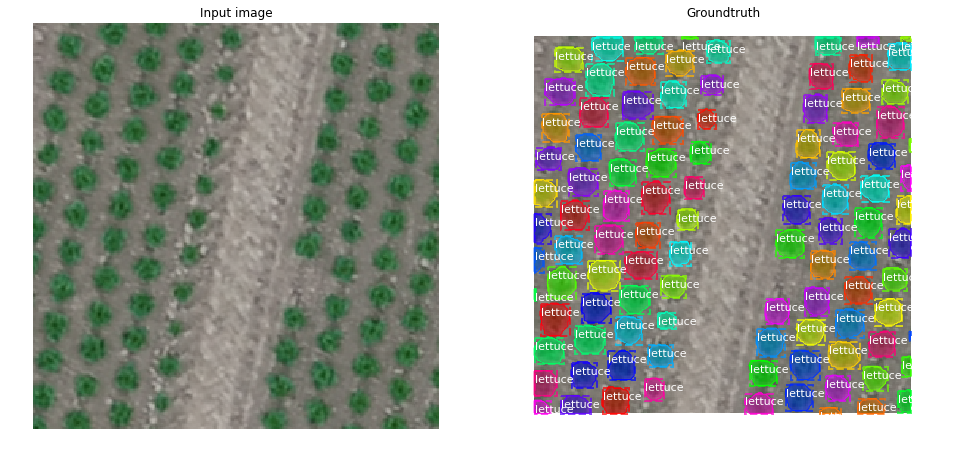

In [11]:
# Test on a  image


image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

axs_=get_ax(rows=1, cols=2, size=8)

axs_[0].imshow(original_image)
axs_[0].set_title('Input image')
axs_[0].axis('off')

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names,ax=axs_[1])

axs_[1].set_title('Groundtruth')

plt.show()

Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  200.00000  int64
molded_images            shape: (1, 256, 256, 3)      min: -110.70000  max:   84.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.13310  max:    1.01299  float32


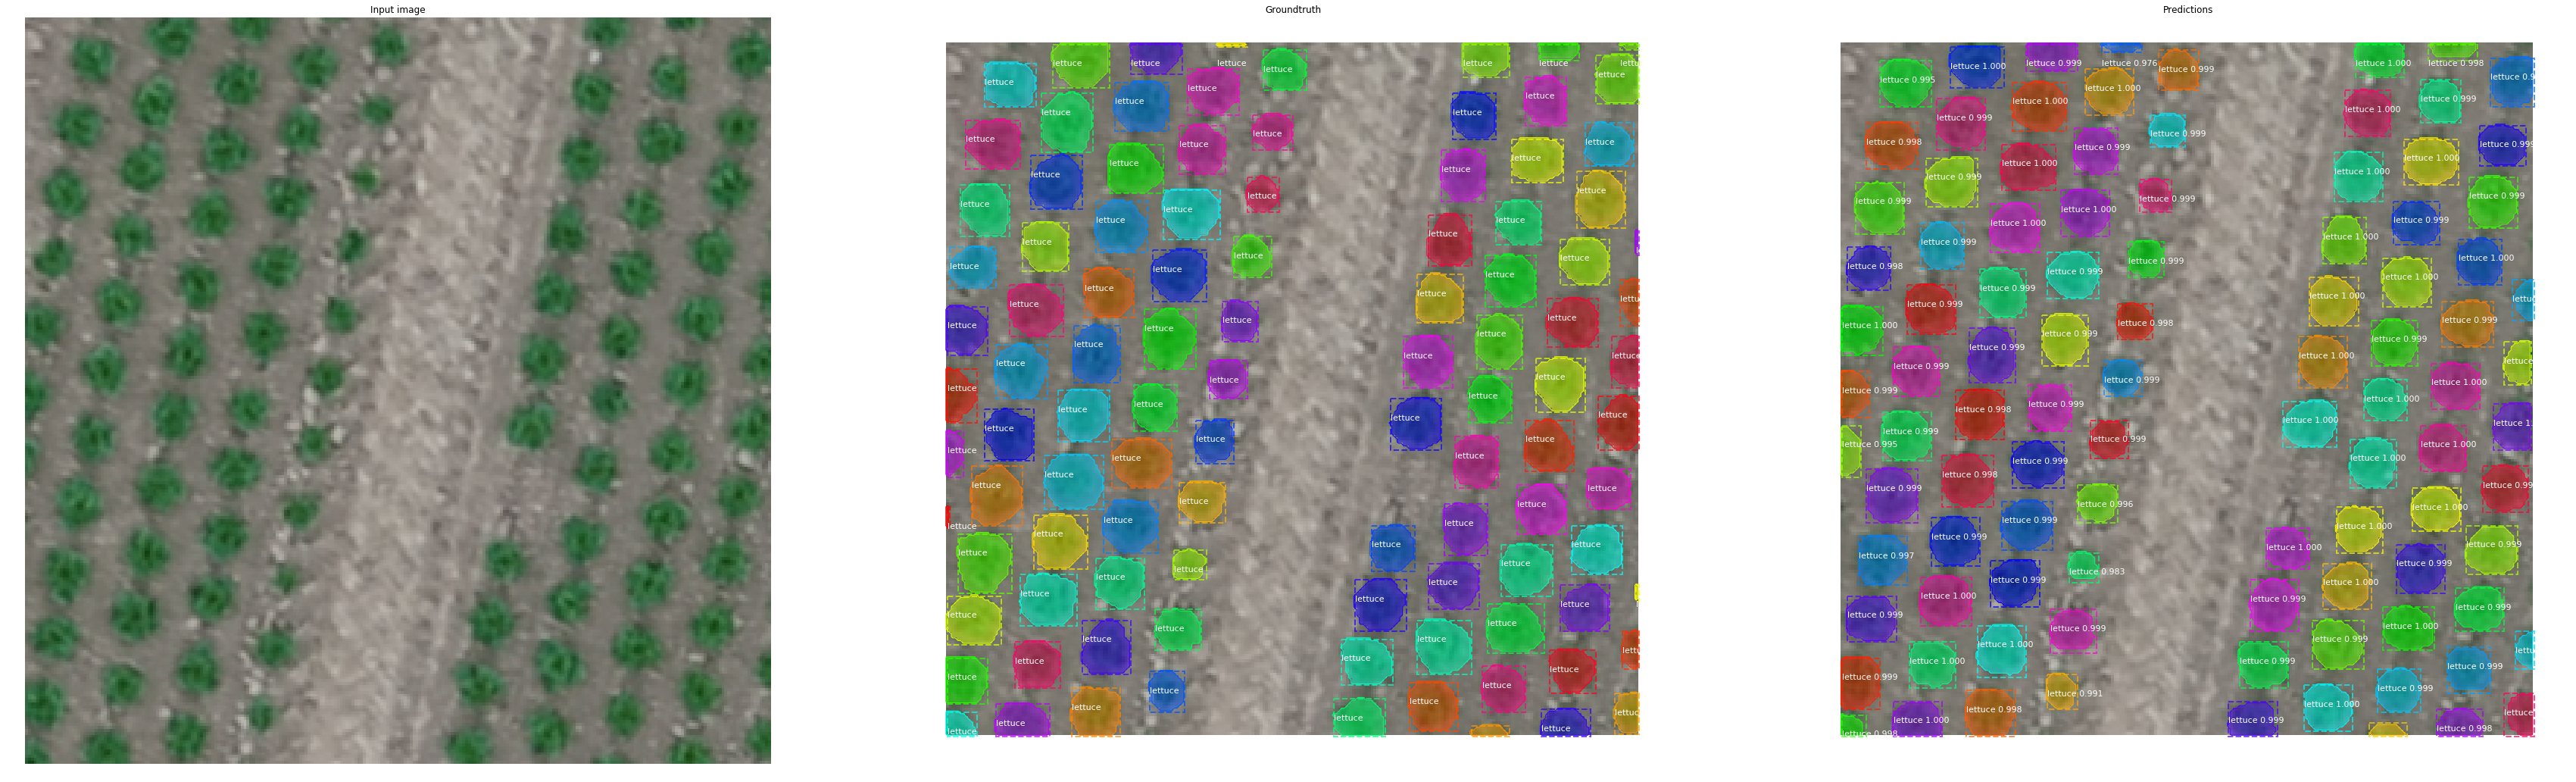

In [12]:
results = model.detect([original_image], verbose=1)


r = results[0]
axs_=get_ax(rows=1, cols=3, size=20)

axs_[0].imshow(original_image)
axs_[0].set_title('Input image')
axs_[0].axis('off')
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names,ax=axs_[1])
axs_[1].set_title('Groundtruth')


visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=axs_[2])
axs_[2].set_title('Predictions')

plt.show()




## Evaluation

In [13]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 70)
image_ids = dataset_test.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9282774567456631


In [14]:
# utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
#                        r['rois'], r['class_ids'], r['scores'], r['masks'],
#                        verbose=1)


In [15]:
dataset_test.image_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])